# MTH793P - Coursework 4 - Part I

This is a template notebook for the computational exercises of Coursework 4, part 1/3, of the module MTH793P, Advanced Machine Learning. 

In this part we will implement the K-means algorithm, and test it on the Old Faithul dataset.<br>
**NOTE:** In this part you should **not**  use any library implementation of K-means, you need to write your own code.

In [1]:
###
### Required imports
###

import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.spatial.distance import cdist
from skimage import img_as_ubyte
from sklearn.metrics import silhouette_score

from numpy.testing import assert_equal
from numpy.testing import assert_almost_equal
from numpy.testing import assert_array_equal
from numpy.testing import assert_array_almost_equal

%matplotlib inline

We begin this week's coursework by loading the Old Faithful dataset with the following cell. The Old Faithful dataset is a well-known dataset in Statistics in Machine Learning. The data includes the waiting time between eruptions and the duration of the eruption for the Old Faithful geyser in Yellowstone National Park, Wyoming, USA. The data can be described as follows:

     A data frame with 272 observations on 2 variables.

    eruptions  numeric  Eruption time in mins
    waiting    numeric  Waiting time to next eruption

For more information, please visit the following references:

     Hardle, W. (1991) Smoothing Techniques with Implementation in S.
     New York: Springer.

     Azzalini, A. and Bowman, A. W. (1990). A look at some data on the
     Old Faithful geyser. Applied Statistics 39, 357-365.

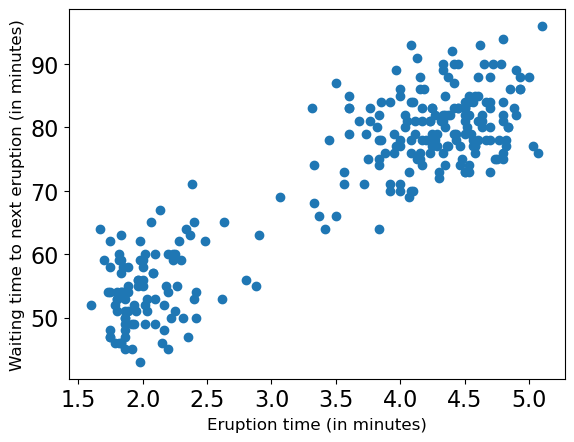

In [2]:
###
### Plotting the Old Faithful data.
###

old_faithful_dataset = np.loadtxt("faithful.csv", delimiter=" ", skiprows=0)
plt.scatter(old_faithful_dataset[:, 0], old_faithful_dataset[:, 1])
plt.xlabel('Eruption time (in minutes)', fontsize=12)
plt.ylabel('Waiting time to next eruption (in minutes)', fontsize=12)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);

## K-means clustering

We write a function **<font color='red'>k_means_clustering</font>** that performs $k$-means clustering for the input **<font color='red'>data</font>** and a number of clusters **<font color='red'>num_clusters</font>** based on the alternating algorithm we discussed in class. <br>
Here **<font color='red'>data</font>** is matrix $X = \left( \begin{matrix} x_1^\top \\ \vdots \\ x_s^\top \end{matrix} \right) \in \mathbb{R}^{s \times d}$ of $s$ $d$-dimensional vectors. 
<br>
Optional arguments are:
1. Initialisation for the centroids (**<font color='red'>init_centroids</font>**).
2. Maximum number of iterations (**<font color='red'>maximum_counter</font>**).
3. Tolerance parameter for when the iteration is considered to have converged (**<font color='red'>tolerance</font>**) .
4. A parameter that determines after how many iterations a progress-update is printed (**<font color='red'>print_output</font>**).

If **<font color='red'>init_centroids</font>** is set to **None**, then it should be initialied as a 2D array of correct size with normal distributed random variables with mean zero and standard deviation one. <br>
Make sure that the algorithm stops as as soon as $\left(L(z^k, \mu^k) - L(z^{k + 1}, \mu^{k + 1})\right) / L(z^{k + 1}, \mu^{k + 1}) \leq \text{tolerance}$. Here, $L$ denotes the k-means clustering objective

$$ L(z, \mu) = \sum_{i = 1}^s \sum_{j = 1}^k z_{ij} \| x_i - \mu_j \|^2 \, . $$

The function should return the following:
- **<font color='red'>centroids</font>** = a matrix $\mu = \left( \begin{matrix} \mu_1^\top \\ \vdots \\ \mu_k^\top \end{matrix} \right) \in \mathbb{R}^{k \times d}$ that contains all $k$ centroid vectors.
- **<font color='red'>assignments</font>** = a matrix $z \in \{0, 1\}^{s \times k}$ that contains the cluster assignments for each sample. <br>

Feel free to make use of your pairwise distance function from Coursework 2, or use the SciPy built-in function [**cdist**](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html).

In [3]:
###
### k_means_clustering
###

def k_means_clustering(data, num_clusters, init_centroids=None, maximum_counter=300, tolerance=1e-9, \
                       print_output=10):   
    ### BEGIN SOLUTION
    N = data.shape[0]
    D = data.shape[1]
    if type(init_centroids).__name__ != "ndarray":
        centroids = np.random.randn(num_clusters, D)
    else:
        centroids = init_centroids

    cost = np.Inf
    counter = 0
    sensitivity = np.Inf 

    while (counter < maximum_counter) and (sensitivity > tolerance):
        previous_cost = cost
        distances = cdist(data, centroids)
       
        assignments = np.zeros((N, num_clusters))
        assignments[np.arange(N), np.argmin(distances, axis=1)] = 1
       
        denominator = np.matlib.repmat(np.sum(assignments, axis=0), D, 1).T
        tmp_denom = denominator
        tmp_denom[denominator == 0] = 1
        tmp = (assignments.T @ data) / tmp_denom
        centroids[denominator > 0] = tmp[denominator > 0]
        
        cost = np.sum(np.min(distances ** 2, axis=1))
        sensitivity = (previous_cost - cost)/cost
        
        if (((counter + 1) % print_output == 0)):
            print('Iteration [%d/%d], sensitivity: %.4f/%.4f, cost: %.2f' 
                   %(counter+1, maximum_counter, sensitivity, tolerance, cost))
        counter += 1
    
    return centroids, assignments
    ### END SOLUTION

You can test your code in the following boxes:

In [4]:
###
### Testing on 1D data.
###

test_data = np.array([-3, 2, -1, 7, 11, 6, -30, 0, -50, 15]).reshape(-1, 1)
test_init_centroids = np.array([-4.0, 0, 1]).reshape(-1, 1)
test_centroids, _ = k_means_clustering(test_data, 3, test_init_centroids)
assert_array_almost_equal(test_centroids, np.array([[-40], [-0.5], [9.75]]))
print("TEST PASSED!")

TEST PASSED!


In [5]:
###
### Testing on 2D data.
###

test_data = np.array([[-3, 2, -1, 7, 11], [6, -30, 0, -50, 15]]).T
test_init_centroids = np.array([[-1.0, 1], [3, -5], [10, 15]])
test_centroids, _ = k_means_clustering(test_data, 3, test_init_centroids)
assert_array_almost_equal(test_centroids, np.array([[-2, 3], [4.5, -40], [11, 15]]))
print("TEST PASSED!")

TEST PASSED!


Cluster the Old Faithful dataset into two clusters. <br> Initialise your centroids with the two centroid vectors $\mu_1 = \left( \begin{matrix} 3.5 & 50\end{matrix}\right)^\top$ and $\mu_2 = \left( \begin{matrix} 3 & 80\end{matrix}\right)^\top$.<br>

Use variables named **<font color='red'>centroids</font>** and **<font color='red'>assignments</font>** to store your results.

In [6]:
### BEGIN SOLUTION
init_centroids = np.array([[3.5, 50], [3, 80]])
centroids, assignments = k_means_clustering(old_faithful_dataset, 2, init_centroids)
### END SOLUTION

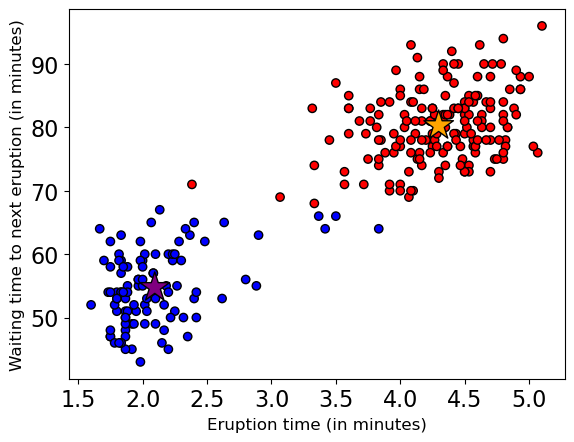

In [7]:
###
### Plotting the resulting clusters.
###

colormap_bright = ListedColormap(['#FF0000', '#0000FF'])
plt.scatter(old_faithful_dataset[:, 0], old_faithful_dataset[:, 1], c=assignments[:, 0], cmap=colormap_bright, edgecolors='k')
plt.scatter(centroids[:, 0], centroids[:, 1], marker="*", s=500, color=["purple", "orange"], edgecolors='k')
plt.xlabel('Eruption time (in minutes)', fontsize=12)
plt.ylabel('Waiting time to next eruption (in minutes)', fontsize=12)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.axis('equal')
plt.tight_layout;

Finally, use the library function [**silhouette_score**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) (imported from sklearn.metrics) to compute the silhouette clustering score for your results.<br>
Place the result in a variable called **<font color='red'>SC</font>**.

In [8]:
### 
### SC = silhouette score
###

### BEGIN SOLUTION
SC = silhouette_score(old_faithful_dataset, assignments[:,0])
### END SOLUTION

print('The silhouette score is: %f' % SC)

The silhouette score is: 0.724055


Does the result you got using K-means look good? can you think of a way to improve it?